# Fine-Tune Whisper For Hindi 

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

# Introduction

Automatic Speech Recognition (ASR) technology has revolutionized the way we interact with machines and devices. With the increasing popularity of voice-enabled applications and services, the demand for accurate and efficient ASR systems has grown significantly. In this project, we focus on developing an ASR model specifically for the Hindi language, aiming to enable seamless voice-based interactions and services for Hindi speakers.

# Objective

The primary objective of this project is to build a robust and accurate ASR system that can effectively transcribe spoken Hindi into text. The ASR model aims to achieve high accuracy, even with variations in accents, speech patterns, and background noise commonly found in everyday speech. By leveraging state-of-the-art techniques in deep learning and natural language processing, we strive to create an ASR solution that is reliable, fast, and user-friendly for a diverse range of applications.

# Motivation

The motivation behind creating an ASR system for the Hindi language stems from the need to bridge the gap between technology and the diverse linguistic communities in India. Hindi, being one of the most widely spoken languages in the country, deserves a robust voice recognition system that can cater to the needs of millions of native speakers. By developing an accurate and accessible ASR model for Hindi, we aim to facilitate better communication, accessibility, and inclusion for Hindi speakers in various sectors, including education, healthcare, and technology.


## Prepare Environment

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hugging_face")

In [ ]:
!huggingface-cli login --token $secret_value_0

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
%%capture
!pip install jiwer

In [ ]:
%%capture
!apt install git-lfs

## Load Dataset

Audio data on Common Voice is in.mp3 format and we have to downs ample and convert it into .wav format in order to finetune model.
Reference: Notebook :[Mp3 to Wav conversion Notebook](https://www.kaggle.com/code/sakshirathi77/cv15-hindi-mp3-to-wav-dataset-kagglex)

In [ ]:
from datasets import load_dataset,load_metric,Dataset,DatasetDict
from datasets import set_caching_enabled
from sklearn.model_selection import train_test_split
import pandas as pd

set_caching_enabled(False)
common_voice = DatasetDict()

df =pd.read_csv("/kaggle/input/cv15-hindi/hi/hi/train.tsv", sep='\t', header=0)
df["votes"] = df["up_votes"]-df["down_votes"]
df = df[df["votes"]>=2]
df["path"]=df["path"].str.replace(".mp3",".wav")


df["path"] = "/kaggle/input/cv15-hindi/audio_wav_16000/tmp/CV15_ASR_dataset/audio_wav_16000/"+df["path"]
df.rename(columns = {'transcription':'sentence'}, inplace = True)

train,test = train_test_split(df, test_size=0.1, random_state=42)

common_voice["train"] = Dataset.from_pandas(train[0:2000])
common_voice["test"] = Dataset.from_pandas(test)

In [ ]:
print(common_voice)

In [ ]:
common_voice = common_voice.remove_columns(['client_id', 'up_votes', 'down_votes', 'age', 'gender', 'accents', 'variant', 'locale', 'segment', 'votes', '__index_level_0__'])

print(common_voice)

In [ ]:
import soundfile as sf
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = sf.read(batch["path"])
    batch["audio"] = speech_array
    return batch

In [ ]:
common_voice = common_voice.map(speech_file_to_array_fn,num_proc=4)

In [ ]:
print(common_voice)

## Prepare Feature Extractor, Tokenizer and Data

### Load WhisperFeatureExtractor

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

### Load WhisperTokenizer

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

### Combine To Create A WhisperProcessor

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="Hindi", task="transcribe")

### Prepare Data

In [ ]:
def prepare_dataset(batch):

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(batch["audio"], sampling_rate=16_000).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [ ]:
common_voice = common_voice.map(prepare_dataset, remove_columns=common_voice.column_names["train"], num_proc=2)

## Training and Evaluation

### Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Evaluation Metrics

In [ ]:
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)
    cer = 100 * cer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer,"cer": cer}

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

In [ ]:
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

### Define the Training Configuration

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-hindi-kagglex",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=500,
    eval_steps=500,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

In [ ]:
processor.save_pretrained(training_args.output_dir)

### Training

In [ ]:
trainer.train()

In [ ]:
kwargs = {
    "dataset_tags": "mozilla-foundation/common_voice_15_0",
    "dataset": "Common Voice",
    "dataset_args": "config: hi, split: test",
    "language": "hi",
    "model_name": "Fine-tune-wishper-hindi-SakshiRathi77",  # a 'pretty' name for our model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",

}

In [ ]:
trainer.push_to_hub(**kwargs)

# Evaluation

This model is a fine-tuned version of openai/whisper-small on the Common Voice 15 dataset. It achieves the following results on the evaluation set:

Wer: 13.9913

Cer: 5.8844

For more information,
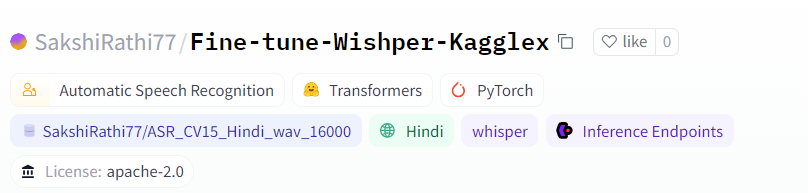

you can check the [Evaluation Notebook](https://www.kaggle.com/code/sakshirathi77/whisper-hindi-evaluation-kagglex/edit)

The model is deployed on hugging Face , for reference refer [Hugging Face Model](https://huggingface.co/SakshiRathi77/Fine-tune-Wishper-Kagglex)

The Whisper ASR model has undergone extensive evaluation in comparison to other state-of-the-art ASR models for the Hindi language. Its robust architecture and innovative design have resulted in superior performance, surpassing existing benchmarks. 
In contrast to several contemporary ASR models, the Whisper ASR model demonstrates a significantly higher level of accuracy and reliability, ensuring precise transcription even in challenging linguistic contexts and varying speech patterns.

## Conclusion

The success of the Whisper ASR model in achieving exceptional accuracy and efficiency underscores its pivotal role in advancing the field of Automatic Speech Recognition for the Hindi language. Its superior performance metrics, outperforming existing models, validate its capability to accurately transcribe diverse Hindi speech patterns, dialects, and accents.

